# Some words to start with...

This notebook is a starter for the DT2119 group project. The performance needs to be improved.

## things can be directly used
1. code for dataset (except collate_fn_dense)
2. code for training

## things need to be improved:
1. code for model (implemented by dense layer, can be improved to 1dcnn)
2. https://github.com/yjlolo/vae-audio

In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import time
import random
import numpy as np
from sklearn.decomposition import PCA

from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
import IPython.display as ipd
from torchaudio.datasets import SPEECHCOMMANDS
import os
from tqdm import tqdm

In [2]:
SPEECHCOMMANDS("./", download=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [162]:
class CONFIG:
    datebase_path = "/content/SpeechCommands/speech_commands_v0.02"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_split = 0.2
    test_split = 0.2
    
    audio_length = 16000

    epoches = 10


In [160]:
##############################################
# Dataset
##############################################
def speechcommands_file_reader(path):
    """
    
    """
    labels = ["backward", "bed", "bird", "cat", "dog", "down", "eight", "five", \
              "follow", "forward", "four", "go", "happy", "house", "learn", \
              "left", "marvin", "nine", "no", "off", "on", "one", "right", \
              "seven", "sheila", "six", "stop", "three", "tree", "two", "up", \
              "visual", "wow", "yes", "zero"]

    label2id = {}
    id2label = {}
    for i, label in enumerate(labels):
        label2id[label] = i
        id2label[i] = label

    flist = []
    for label in labels:
        sub_path = os.path.join(path, label)
        id = label2id[label]
        for f in os.listdir(sub_path):
            total_path = os.path.join(sub_path, f)
            flist.append((id, total_path))

    return label2id, id2label, flist

def train_test_split(flist, test_split):
    n = len(flist)
    random.shuffle(flist)
    return flist[: -int(test_split*n)],   flist[-int(test_split*n):]


class speechCommandDataset(Dataset):
    def __init__(
        self, 
        flist, 
        audio_length=16000
        ):

        self.flist = flist
        self.audio_length = audio_length
        self.loader = torchaudio.load

    def __len__(self):
        return len(self.flist)

    def __getitem__(self, index):
        label, f = self.flist[index]
        audio, samplerate = self.loader(f)

        residual = self.audio_length - audio.size(1)
        if residual:
            left_pad = np.random.choice(residual)
            right_pad = residual - left_pad
            p1d = (left_pad, right_pad) # pad last dim by num_pad on the right side
            audio = F.pad(audio, p1d, "constant", 0) 

        return audio, label
    
    def getDataloader(self, batchSize):
        print("hi dataloader!")
        return DataLoader(
            dataset=self, 
            batch_size=batchSize,
            collate_fn = collate_fn_dense,
            shuffle=True,
            drop_last=True
        )

def collate_fn_dense(batch):
    """
    squeeze the data from (batch * 1 * audio_length) to (batch * 1 * audio_length) 
    only suitable for VAE with dense-layer
    """
    audios, targets = [], []

    for audio, label in batch:
        audios += [audio]
        targets.append(label)
        #print(label)

    audios = torch.vstack(audios)
    targets = np.array(targets)

    return audios, targets


def collate_fn_1dcc(batch):
    pass
##############################################
# Model
# Now the VAE is implemented by dense layers, it could be 1d-cnn afterwards
##############################################

class VariationalEncoder(nn.Module):
    def __init__(self, input_dims, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, 512)
        self.dropout1 = nn.Dropout(0.4)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(CONFIG.device)
        self.N.scale = self.N.scale.to(CONFIG.device)
        self.kl = 0
    
    def forward(self, x):
        #x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z



class Decoder(nn.Module):
    def __init__(self, latent_dims, output_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, output_dims)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z


class VariationalAutoencoder(nn.Module):
    def __init__(self,input_dims, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_dims, latent_dims)
        self.decoder = Decoder(latent_dims, input_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)



##############################################
# Training
###############################################

def train_one_step(model, optimizer, dataloader):
    model.train()
    t = time.time()
    total_loss = 0

    for step, (audio, label) in enumerate(dataloader):
        
        
        audio = audio.to(CONFIG.device)
        reconstructed_audio = model(audio)

        optimizer.zero_grad()
        loss = (torch.square(reconstructed_audio - audio)).sum() + model.encoder.kl
        loss.backward()
        optimizer.step()

        batchsize = audio.size()[0]
        total_loss += loss.detach().cpu().numpy().sum()/batchsize

        if (step+1) % 10000 == 0:    
            print(f"--> train step {step}, loss {loss.detach().cpu().numpy().sum()/batchsize:.5f}, time {time.time()-t:.5f}")
    
    return total_loss/len(dataloader)


        
##############################################
# Utilities
###############################################

def plot_latent(model, dataloader):
    plt.figure(figsize=(10,8))
    pca = PCA(n_components=2, svd_solver='randomized')
    for i, (x, y) in enumerate(dataloader):
        z = model.encoder(x.to(CONFIG.device))
        z = z.detach().cpu().numpy()

        z = pca.fit_transform(z)
        plt.scatter(z[:, 0], z[:, 1], c=y)

        if i > 5:
            break
    plt.title("Distribution of Latent Space")
    plt.colorbar()
    plt.show()

In [164]:
label2id, id2label, flist = speechcommands_file_reader(CONFIG.datebase_path)
train_flist, test_flist = train_test_split(flist, CONFIG.test_split)

train_dataset = speechCommandDataset(train_flist)
train_dataloader = train_dataset.getDataloader(256)

model = VariationalAutoencoder(16000, 256).to(CONFIG.device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


hi dataloader!


In [165]:
for epoch in range(CONFIG.epoches):
    t = time.time()
    train_loss = train_one_step(model, optimizer, train_dataloader)
    print(f"[RESULT] Epoch: {epoch}  Loss: {train_loss:.5f}  Time: {time.time()-t:.5f} ")


[RESULT] Epoch: 0  Loss: 908.26590  Time: 25.24312 
[RESULT] Epoch: 1  Loss: 248.00989  Time: 25.34405 
[RESULT] Epoch: 2  Loss: 229.47091  Time: 25.46035 
[RESULT] Epoch: 3  Loss: 224.06120  Time: 26.18222 
[RESULT] Epoch: 4  Loss: 221.55401  Time: 25.20810 
[RESULT] Epoch: 5  Loss: 220.03755  Time: 25.20468 
[RESULT] Epoch: 6  Loss: 218.94859  Time: 25.35086 
[RESULT] Epoch: 7  Loss: 218.04381  Time: 25.36254 
[RESULT] Epoch: 8  Loss: 217.12954  Time: 26.53326 
[RESULT] Epoch: 9  Loss: 216.47709  Time: 25.67018 


In [166]:
test_dataset = speechCommandDataset(test_flist)
test_dataloader = train_dataset.getDataloader(256)

hi dataloader!


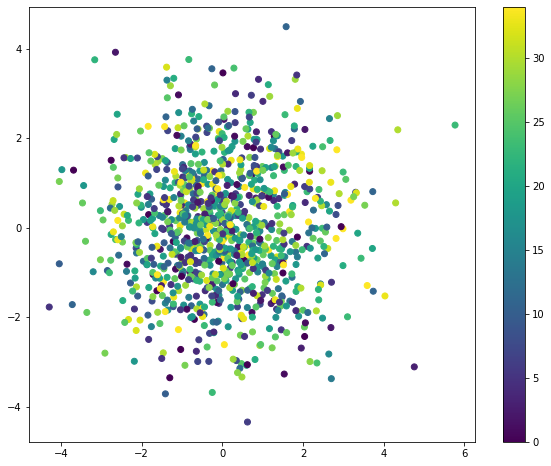

In [167]:
plot_latent(model, test_dataloader)

# backup

In [14]:
a = SPEECHCOMMANDS("./", download=True)
l = []
for i in range(len(a)):
    ll = a[i][0].size()[1]
    l.append(ll)